In [8]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [1]:
from fastbook import *
from fastai.vision.widgets import *

In [26]:
shutil.rmtree('images')

In [38]:
key = os.environ.get('AZURE_SEARCH_KEY', 'c523df92a7a34970bc5a1a8eb369ec57')

In [39]:
results = search_images_bing(key,'cars')
ims = results.attrgot('contentUrl')
len(ims)

150

In [40]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [41]:
dest = 'images/car.jpg'
download_url(ims[0], dest)

Path('images/car.jpg')

In [42]:
 os.listdir("images")

['car.jpg']

In [45]:
cars_type = 'audi','porsche', 'mustang'
path = Path('cars')

In [48]:
if not path.exists():
    path.mkdir()
    for o in cars_type:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} car')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [49]:
fns = get_image_files(path)
fns

(#440) [Path('cars/audi/0294b0f5-e889-4473-b3ab-2af90b8c234b.jpg'),Path('cars/audi/02e88f7c-6f6e-4fa6-adae-ec82eeb780e0.jpg'),Path('cars/audi/05ea3928-e054-4456-bdbc-5f97b47a807b.jpg'),Path('cars/audi/0967e309-3b35-4b32-bf08-45abea490eb8.jpg'),Path('cars/audi/0bacdb29-3f30-4ae4-91c0-701c7d8a9d27.jpg'),Path('cars/audi/0c5c295e-ac5a-4274-affa-e5abc6ad4cad.jpg'),Path('cars/audi/0cfaaaa6-6daf-4dc3-aa92-d2df66f332ca.jpg'),Path('cars/audi/0d23df90-812d-49ba-bcf6-beae606eaff9.jpg'),Path('cars/audi/100f81a0-e714-4bd4-b6ad-8786933f581b.jpg'),Path('cars/audi/110ae07b-a699-4769-bd62-b37f4653da0f.jpg')...]

In [50]:
failed = verify_images(fns)
failed

(#64) [Path('cars/audi/02e88f7c-6f6e-4fa6-adae-ec82eeb780e0.jpg'),Path('cars/audi/0c5c295e-ac5a-4274-affa-e5abc6ad4cad.jpg'),Path('cars/audi/110ae07b-a699-4769-bd62-b37f4653da0f.jpg'),Path('cars/audi/2ef6a73f-3ee6-4fd7-bb32-0ef4605925ff.jpg'),Path('cars/audi/40f48c12-4450-4032-b08e-6fc0fd3286b5.jpg'),Path('cars/audi/4279eaf5-79e6-4cf4-af06-f11c05ef1628.jpg'),Path('cars/audi/5465a7b3-f376-4f0a-834a-eec8b57eee2b.jpg'),Path('cars/audi/5ba6770a-5808-49fa-a7e2-4363497b99c1.jpg'),Path('cars/audi/7bf19e10-3932-417e-8873-a473f8ef24e7.jpg'),Path('cars/audi/90ebc020-d377-4383-9779-880a845c2f27.jpg')...]

In [51]:
failed.map(Path.unlink)

(#64) [None,None,None,None,None,None,None,None,None,None...]

In [52]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [53]:
dls = cars.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


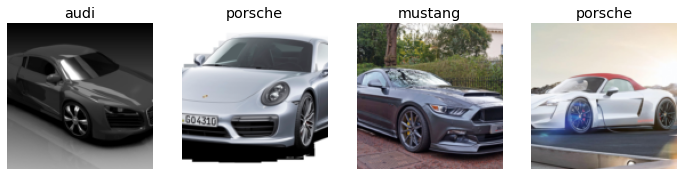

In [54]:
dls.valid.show_batch(max_n=4, nrows=1)

In [55]:
cars = cars.new(
    item_tfms=RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms=aug_transforms())
dls = cars.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [56]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.942536,1.266933,0.546667,00:53


epoch,train_loss,valid_loss,error_rate,time
0,1.530637,1.137019,0.533333,00:59
1,1.363554,0.970074,0.480000,00:59
2,1.157440,0.834884,0.386667,01:00
3,1.014358,0.805077,0.293333,01:01
4,0.912109,0.806015,0.266667,01:01


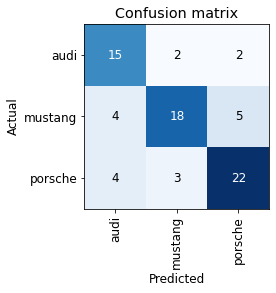

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

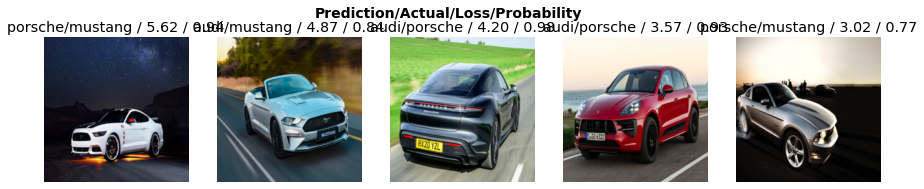

In [58]:
interp.plot_top_losses(5, nrows=1)

In [59]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [60]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Error: Destination path 'cars\porsche\97269f29-507c-47ba-86a2-58c47f2c9520.jpg' already exists

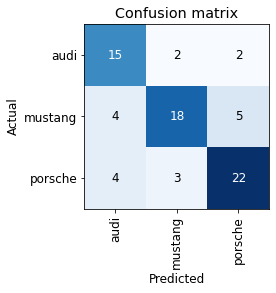

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [62]:
learn.export()

In [63]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [64]:
learn_inf = load_learner(path/'export.pkl')

In [65]:
learn_inf.predict('images/car.jpg')

('audi', TensorBase(0), TensorBase([0.6696, 0.0104, 0.3200]))

In [68]:
learn_inf.dls.vocab

['audi', 'mustang', 'porsche']

In [69]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [71]:
img = PILImage.create(btn_upload.data[-1])

In [72]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [74]:
pred,pred_idx,probs = learn_inf.predict(img)

In [75]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: audi; Probability: 0.7388')

In [77]:
btn_run = widgets.Button(description='Klasyfikuj')
btn_run

Button(description='Klasyfikuj', style=ButtonStyle())

In [78]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [84]:
btn_upload = widgets.FileUpload(description='Wgraj obraz')

In [85]:
VBox([widgets.Label('Wybierz samochód'),
     btn_upload, btn_run, out_pl, lbl_pred])